<a href="https://colab.research.google.com/github/h-i-e-u/img-classifier/blob/main/pho_or_not_pho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Pho or Not Pho` follow [Youtube Video: Hot Dog vs Not Hot Dog](https://www.youtube.com/watch?v=nVhau51w6dM)




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

In [2]:
ds, ds_info = tfds.load("food101", shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.A1DU5E_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.A1DU5E_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
train_ds, valid_ds = ds["train"], ds["validation"]

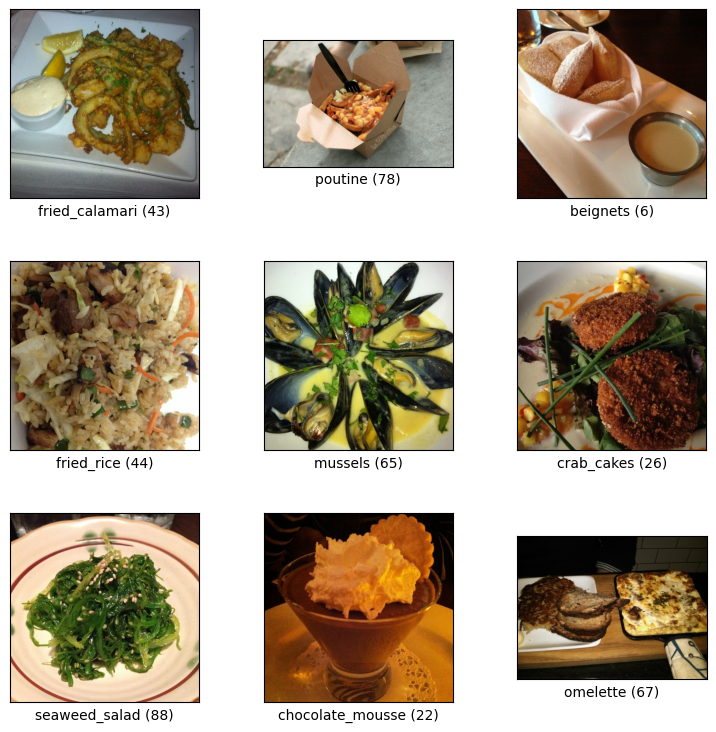

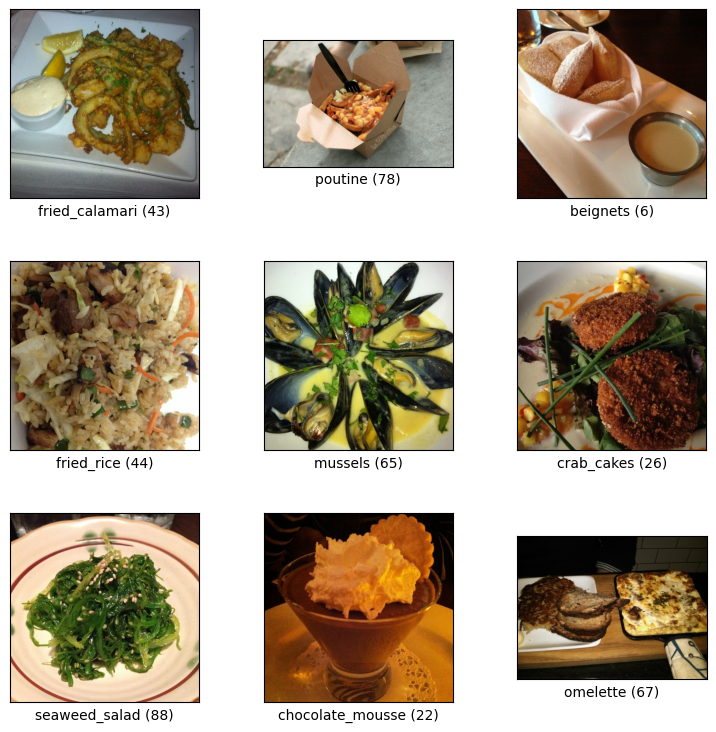

In [4]:
tfds.show_examples(train_ds, ds_info)

In [5]:
MAX_SIDE_LEN = 256
PHO_CLASS = 75
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == PHO_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == PHO_CLASS, dtype=tf.int32))
)

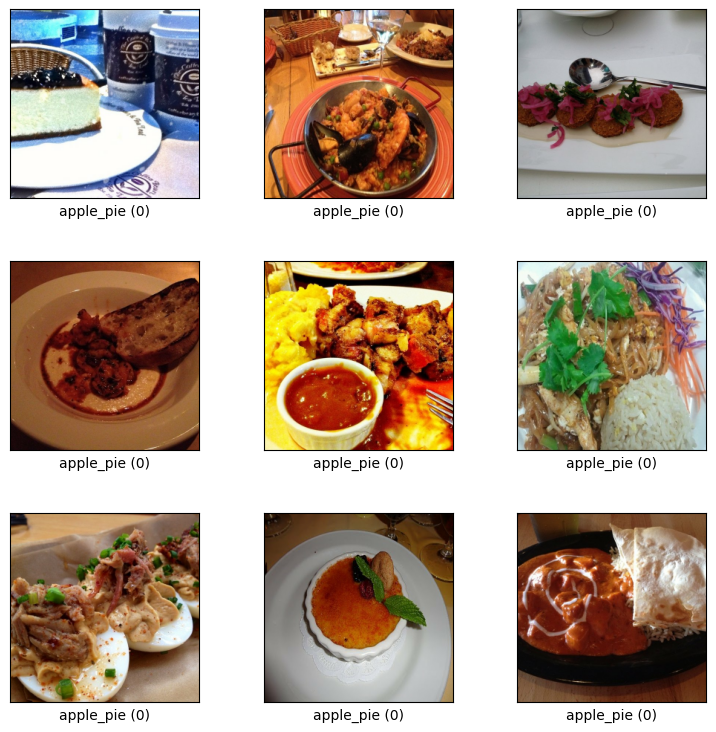

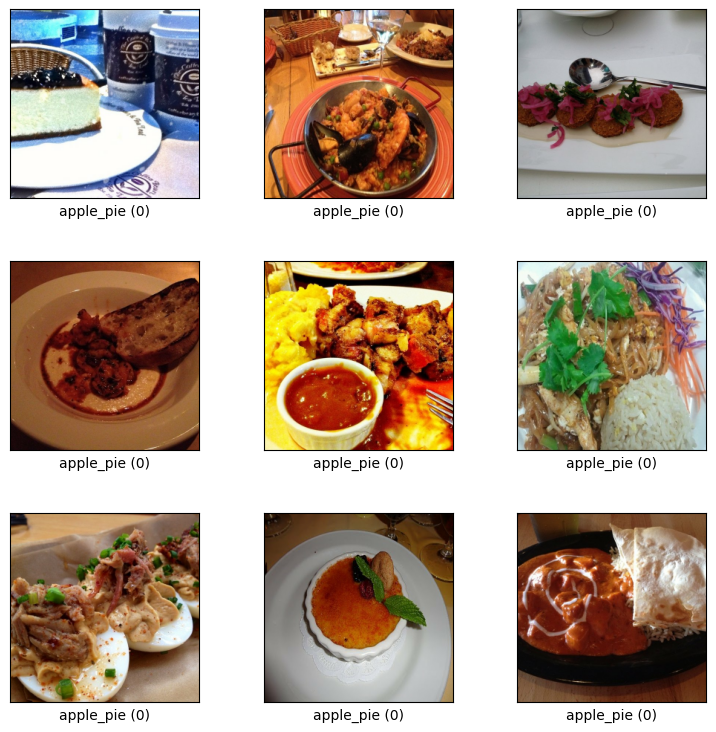

In [6]:
tfds.show_examples(train_ds, ds_info)

In [7]:
# train data
train_pho_size, valid_pho_size = 750, 250
train_phos = train_ds.filter(lambda _, label: label ==1).repeat(3)
train_not_phos = train_ds.filter(lambda _, label: label ==0)

# valid data
valid_phos = valid_ds.filter(lambda _, label: label ==1)
valid_not_phos = valid_ds.filter(lambda _, label: label ==0)

In [8]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_phos, train_not_phos], weights=[0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_phos, valid_not_phos], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

implement

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [10]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.20))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.20))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.20))
model.add(layers.Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/30
    286/Unknown 419s 1s/step - accuracy: 0.5479 - loss: 1.5703

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


286/286 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.5480 - loss: 1.5697 - val_accuracy: 0.6774 - val_loss: 1.1352
Epoch 2/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - accuracy: 0.6943 - loss: 1.0776 - val_accuracy: 0.7735 - val_loss: 0.8866
Epoch 3/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.7590 - loss: 0.8611 - val_accuracy: 0.7916 - val_loss: 0.7602
Epoch 4/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.8047 - loss: 0.7286 - val_accuracy: 0.8196 - val_loss: 0.6968
Epoch 5/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.8389 - loss: 0.6276 - val_accuracy: 0.8096 - val_loss: 0.6728
Epoch 6/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.8734 - loss: 0.5382 - val_accuracy: 0.8156 - val_loss: 0.6717
Epoch 7/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.8983 - loss: 0.4668 - val_accuracy: 0.8136 - val_loss: 0.6928
Epoch 8/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9236 - loss: 0.4086 - val_accurac

In [13]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(valid_ds)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7612 - loss: 1.1636
Validation Loss: 1.1539803743362427
Validation Accuracy: 0.7595190405845642


In [20]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

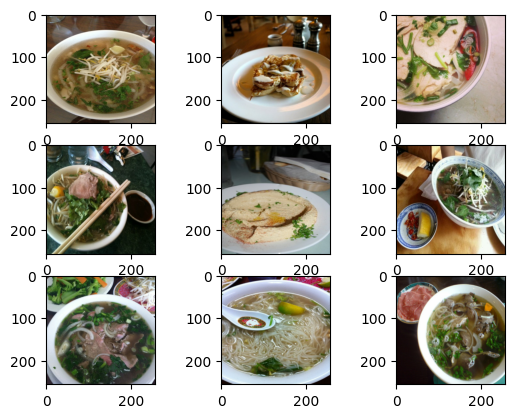

In [24]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])

In [25]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32)>

In [27]:
# Save the entire model in the SavedModel format
model_save_path = "/tmp/pho_or_not_pho_model.keras"
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /tmp/pho_or_not_pho_model.keras
